## Practice: Sequence to Sequence for Neural Machne Translation.

*This notebook is based on [open-source implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) of seq2seq NMT in PyTorch.*

We are going to implement the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. 

The model will be trained for German to English translations, but it can be applied to any problem that involves going from one sequence to another, such as summarization.


## Introduction

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which (commonly) use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. You can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

![](img/seq2seq1.png)

The above image shows an example translation. The input/source sentence, "guten morgen", is input into the encoder (green) one word at a time. We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the current word, $x_t$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. You can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $x_t$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(x_t, h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). 

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the current word, $y_t$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(y_t, s_{t-1})$$

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called *teacher forcing*, and you can read about it more [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

## Preparing Data

We'll be coding up the models in PyTorch and using TorchText to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

Uncomment the next cell if `torchtext` is not present on your machine.

In [1]:
# ! pip install torchtext

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

We'll set the random seeds for deterministic results.

In [3]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word. 

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model. 

**Note**: the models must first be downloaded using the following on the command line: 
```
python -m spacy download en
python -m spacy download de
```

Uncomment the next cell if you are using Colab or it's the first time you work with this notebook.

__If you a working on local machine and in special env, you should run the code below in the exact env the current jupyter kernel is based on.__ E.g. using the following command if you use `conda`:

```
conda activate my_special_env
python -m spacy download en
python -m spacy download de
```

In [4]:
# ! python -m spacy download en
# ! python -m spacy download de

We load the models as such:

In [5]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In the paper we are implementing, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier".

In [6]:
spacy_de.tokenizer('Ich bin')

Ich bin

In [7]:
[tok.text for tok in spacy_en.tokenizer('I am a teacher in the Deep Learning class')]

['I', 'am', 'a', 'teacher', 'in', 'the', 'Deep', 'Learning', 'class']

In [8]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][
        ::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

TorchText's `Field`s handle how data should be processed. You can read all of the possible arguments [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61). 

We set the `tokenize` argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

In [9]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Next, we download and load the train, validation and test data. 

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence. 

`exts` specifies which languages to use as the source and target (source goes first) and `fields` specifies which field to use for the source and target.

In [10]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [11]:
train_data[0].trg

['two',
 'young',
 ',',
 'white',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.']

We can double check that we've loaded the right number of examples:

In [12]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We can also print out an example, making sure the source sentence is reversed:

In [13]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


The period is at the beginning of the German (src) sentence, so looks good!

Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer) and this is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1). The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [14]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [15]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

Let's look up what's stored in train and test iterators:

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.cuda.LongTensor of size 23x128 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 21x128 (GPU 0)]
torch.Size([23, 128]) torch.Size([21, 128])


One could mention, that the first dimention is now `seq_len`, not `batch` as used to be. It's because in PyTorch LSTM (and other recurrent units) await for input in format `(seq_len, batch, input_size)`. Be careful with that (especially in your homework assignment).

## Building the Seq2Seq Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.

### Encoder

First, the encoder, a 2 layer LSTM. The paper we are implementing uses a 4-layer LSTM, but in the interest of training time we cut this down to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers. 

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

Without going into too much detail about LSTMs (see [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) blog post if you want to learn more about them), all we need to know is that they're a type of RNN which instead of just taking in a hidden state and returning a new hidden state per time-step, also take in and return a *cell state*, $c_t$, per time-step.

$$\begin{align*}
h_t &= \text{RNN}(x_t, h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(x_t, (h_{t-1}, c_{t-1}))
\end{align*}$$


You can just think of $c_t$ as another type of hidden state. Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.

So our encoder looks something like this: 

![](img/seq2seq2.png)

We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:
- `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
- `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `emb_dim` dimensions. 
- `hid_dim` is the dimensionality of the hidden and cell states.
- `n_layers` is the number of layers in the RNN.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

To get more info about `nn.Embedding` one could refer to these articles: [1](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/), [2](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html), [3](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), [4](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/). 

The embedding layer is created using `nn.Embedding`, the LSTM with `nn.LSTM` and a dropout layer with `nn.Dropout`. Check the PyTorch [documentation](https://pytorch.org/docs/stable/nn.html) for more about these.

One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence for us! You may notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros. 

The RNN returns: `outputs` (the top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`. 

The sizes of each of the tensors is left as comments in the code. In this implementation `n_directions` will always be 1, because for now we are working only with one-direction LSTM.

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )# <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout) # <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
                
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        output, (hidden, cell) = self.rnn(embedded) # <YOUR CODE HERE> 

        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer (4 in the paper) LSTM.

![](img/seq2seq3.png)

The `Decoder` class does a single step of decoding. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feed it through the LSTM with the current token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(y_t, (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$. 

$$\hat{y}_{t+1} = f(s_t^L)$$

The arguments and initialization are similar to the `Encoder` class, except we now have an `output_dim` which is the size of the one-hot vectors that will be input to the decoder. These are equal to the vocabulary size of the output/target. There is also the addition of the `Linear` layer, used to make the predictions from the top layer hidden state.

Within the `forward` method, we accept a batch of input tokens, previous hidden states and previous cell states. We `unsqueeze` the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an `output` (hidden state from the top layer of the RNN), a new `hidden` state (one for each layer, stacked on top of each other) and a new `cell` state (also one per layer, stacked on top of each other). We then pass the `output` (after getting rid of the sentence length dimension) through the linear layer to receive our `prediction`. We then return the `prediction`, the new `hidden` state and the new `cell` state.

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        ) # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )# <YOUR CODE HERE>
        
        self.out = nn.Linear(hid_dim, output_dim) # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout) # <YOUR CODE HERE> 
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input)) # <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell)) # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle: 
- receiving the input/source sentence
- using the encoder to produce the context vectors 
- using the decoder to produce the predicted output/target sentence

Our full model will look like this:

![](img/seq2seq4.png)

The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

For this implementation, we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the `Encoder` and `Decoder`. This is not always the case, you do not necessarily need the same number of layers or the same hidden dimension sizes in a sequence-to-sequence model. However, if you do something like having a different number of layers you will need to make decisions about how this is handled. For example, if your encoder has 2 layers and your decoder only has 1, how is this handled? Do you average the two context vectors output by the decoder? Do you pass both through a linear layer? Do you only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.  

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, $X$/`src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended (all the way back when we defined the `init_token` in our `TRG` field) we get our $y_1$ by slicing into it. We know how long our target sentences should be (`max_len`), so we loop that many times. During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
    - if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`
    
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/`outputs`.

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

# Training the Seq2Seq Model

Now we have our model implemented, we can begin training it. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`.

In [46]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [47]:
model(x.src, x.trg).shape

torch.Size([21, 128, 5893])

In [48]:
x.trg.shape

torch.Size([21, 128])

Next up is initializing the weights of our model. In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08, i.e. $\mathcal{U}(-0.08, 0.08)$.

We initialize weights in PyTorch by creating a function which we `apply` to our model. When using `apply`, the `init_weights` function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.

In [49]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,899,013 trainable parameters


We define our optimizer, which we use to update our parameters in the training loop. Check out [this](http://ruder.io/optimizing-gradient-descent/) post for information about different optimizers. Here, we'll use Adam.

In [51]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions. 

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [52]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    - we also don't want to measure the loss of the `<sos>` token, hence we slice off the first column of the output and target tensors
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [53]:
PLOT_STEP = 0

In [54]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, plot_local=False, writer=None):
    global PLOT_STEP
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            PLOT_STEP += i
            if writer is not None:
                writer.add_scalar('train loss', history[-1], PLOT_STEP)
            
            if plot_local:
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

                clear_output(True)
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epoch')
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                plt.legend()

                plt.show()

        
    return epoch_loss / len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [55]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [56]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [57]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [58]:
example_input = next(iter(train_iterator))

In [59]:
example_input.src.shape

torch.Size([30, 128])

In [116]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we can be more specific here
writer = SummaryWriter('~/tensorboard_files/')

In [117]:
writer.add_graph(model, (example_input.src[:1], example_input.trg[:1]))
writer.close()

<ipython-input-22-35112cd5eeef>:35: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  for t in range(1, max_len):


In [62]:
import numpy as np

In [63]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for t in range(1, max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        #insert input token embedding, previous hidden state and all encoder hidden states
        #receive output tensor (predictions) and new hidden state
        output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [64]:
def get_example_translation():
    example_idx = np.random.choice(np.arange(len(test_data)))

    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    
    src_string = f'src = {" ".join(src)}'
    trg_string = f'trg = {" ".join(trg)}'

    translation = translate_sentence(src, SRC, TRG, model, device)
    
    translation_string = f'predicted trg = {" ".join(translation)}'

#     print(src_string)
#     print()
#     print(trg_string)
#     print()
#     print(translation_string)
    
    return ('\n\n'.join([src_string, trg_string, translation_string]))

Let's call the `tensorboard` here (if you are working on Colab). If you work locally better run it as another process in your terminal using the command
```
tensorboard --logdir .runs/ --reload_interval=5
```

In [65]:
# On Colab just uncomment and run this cell

# %load_ext tensorboard
# %tensorboard --logdir runs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [66]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

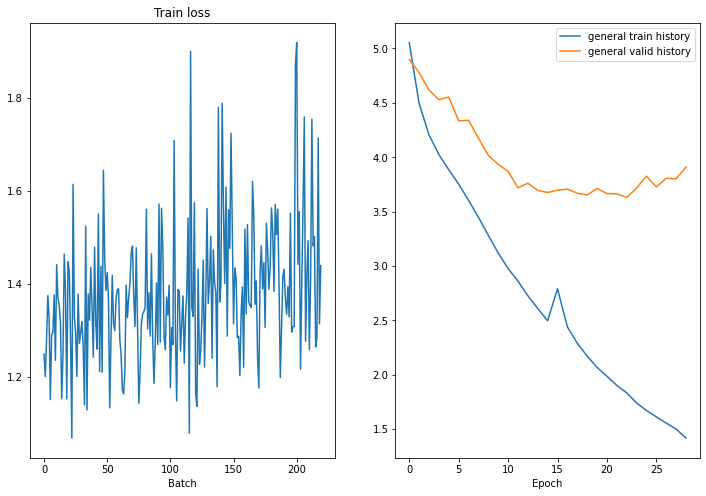

In [113]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(
        model,
        train_iterator,
        optimizer,
        criterion,
        CLIP,
        train_history,
        valid_history,
        writer=writer,
        plot_local=True
    )
    http://localhost:7007/notebooks/ml_courses/harbour_dlia2020/day03/practice03_seq2seq_NMT.ipynb#
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    writer.add_scalar('mean train loss per epoch', train_loss, global_step=epoch)
    writer.add_scalar('mean val loss per epoch', valid_loss, global_step=epoch)

    val_example_data = next(iter(valid_iterator))
    to_print = []
    
    
    writer.add_text('translation example', get_example_translation(), global_step=epoch)
    writer.close()

#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [114]:
print(get_example_translation())

src = . hat gesenkt kopf seinen der , hemd schwarz-weißen raffinierten einem mit junge ein

trg = a young boy wearing a clever black and white shirt with his head bowed down

predicted trg = a boy with a black and white sleeved shirt , his his head bowed . <eos>


In [115]:
print(get_example_translation())

src = . fahrrad straße verschneiten einer auf fährt person eine

trg = a person riding a bike on a snowy road .

predicted trg = person riding a bike on a dirt road . <eos>


We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [103]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.515 | Test PPL: 248.338 |
